# Introduction

This notebook simulates the top mass reweighting by using Gaussian with mean and variance of the top mass dataset. It investigates the effect of statistics size to reweighting results. It appears that with large enough data points, the reweighting can work better (around 10^6 in this case)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Imports

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate
from tensorflow.keras.backend import set_value
# standard numerical library imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt


/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

# Using mean and standard deviation value from real top mass dataset to reweight from $\mathcal{N}(\mu_0, \sigma_0)$ to $\mathcal{N}(\mu_1, \sigma_1)$

In [4]:
data_dir = 'DCTRFitting/'
default_had_mass = np.load(data_dir + 'part_172_5_6j_obs_x4.npy')[:,1]
truth_had_mass = np.load(data_dir+ 'part_175_0_6j_obs_x4.npy')[:,1]

In [5]:
(mu_0,sigma_0) = np.average(default_had_mass),np.std(default_had_mass)
(mu_1,sigma_1) = np.average(truth_had_mass),np.std(truth_had_mass)

In [6]:
print(mu_0,sigma_0,mu_1,sigma_1)

200.36699082389325 101.76187520314188 202.56594507000284 102.98617012761439


## Build datasets

In [7]:
def reweight(n_data_points, lr = 0.001):
    X0 = np.random.normal(mu_0, sigma_0, n_data_points)
    X1 = np.random.normal(mu_1, sigma_1, n_data_points)
    
    bins = np.linspace(-100,500,50)
    plt.hist(X0, bins = bins, alpha = 0.5, label = r'$\mu=172.5$')
    plt.hist(X1, bins = bins, alpha = 0.5, label = r'$\mu=175$')
    plt.legend()
    plt.title("Data for reweighting")
    plt.show()

    Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
    Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

    X = np.concatenate((X0, X1))
    Y = np.concatenate((Y0, Y1))

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    inputs = Input((1,))
    hidden_layer_1 = Dense(20, activation='relu')(inputs)
    hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', )
    
    set_value(model.optimizer.lr, lr)
    
    epochs_num = 10
    earlystopping = EarlyStopping(patience = epochs_num,)

    history = model.fit(X_train, Y_train, 
              epochs=epochs_num, 
              batch_size = 100,
              validation_data = (X_test, Y_test),
              callbacks = [earlystopping])
    
    plt.plot(history.history['loss'],     label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val loss')
    plt.legend(loc=0)
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.show()
    
    preds = model.predict(X0)
    weights = preds[:,1]/preds[:,0]
    exact_weights = np.exp(-0.5*((mu_0-X0)/sigma_0)**2+0.5*((mu_1-X1)/sigma_1)**2)
    
    bins = np.linspace(0.5,1.5,50)
    plt.hist(weights, bins = bins, alpha = 0.5)[0]
    plt.hist(exact_weights, bins = bins, alpha = 0.5)[0]
    plt.title("Distribution of weight")
    plt.show()
    
    bins = np.linspace(-100,500,50)
    plt.hist(X0, bins = bins, alpha = 0.5, label = r'$\mu=172.5$')
    plt.hist(X0, bins = bins, label = r'$172.5$ weighted', weights=weights, histtype='step', color='k')
    plt.hist(X1, bins = bins, alpha = 0.5, label = r'$\mu=175$')
    plt.legend()
    plt.show()
    
    if (history.history['val_loss'][-1] < 1):
        return True
    else:
        return False

In [8]:
num_trial = 10

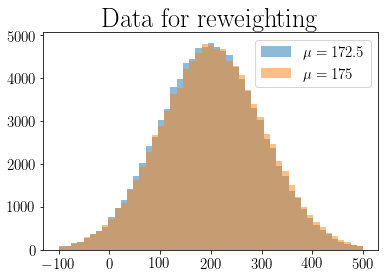

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 50us/step - loss: 1.0543 - val_loss: 0.6934
Epoch 2/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6954 - val_loss: 0.7075
Epoch 3/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6952 - val_loss: 0.6931
Epoch 4/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6953 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6955 - val_loss: 0.6934
Epoch 6/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6952 - val_loss: 0.6942
Epoch 7/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6955 - val_loss: 0.6934
Epoch 8/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6951 - val_loss: 0.6931
Epoch 9/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6951 - val

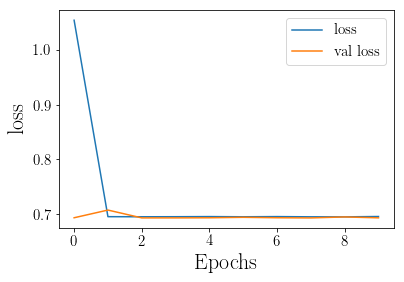

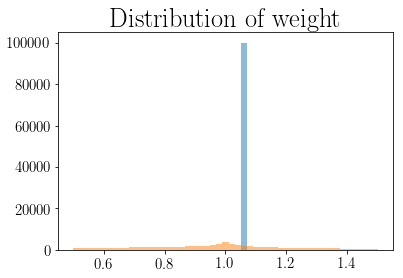

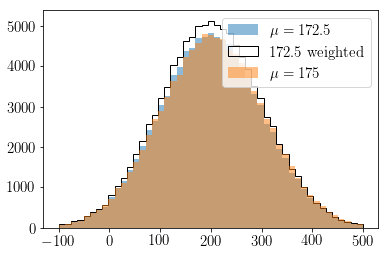

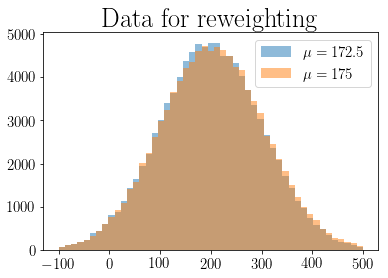

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 54us/step - loss: 5.3933 - val_loss: 0.6956
Epoch 2/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6954 - val_loss: 0.6933
Epoch 3/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6950 - val_loss: 0.6942
Epoch 4/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6954 - val_loss: 0.6951
Epoch 5/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6957 - val_loss: 0.6949
Epoch 6/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6960 - val_loss: 0.7005
Epoch 7/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6955 - val_loss: 0.6950
Epoch 8/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6949 - val_loss: 0.6938
Epoch 9/10
160000/160000 [==============================] - 7s 45us/step - loss: 0.6956 - val

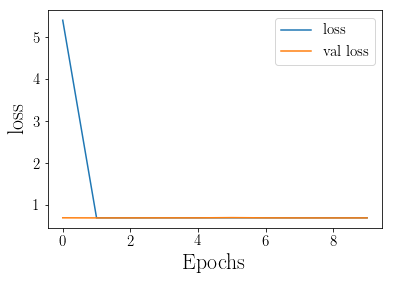

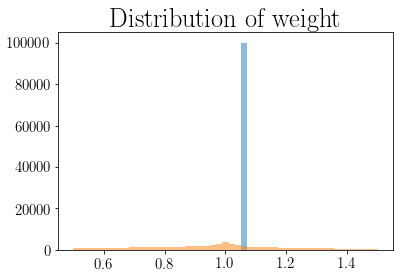

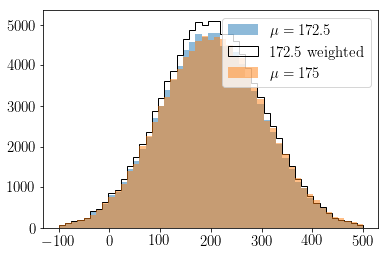

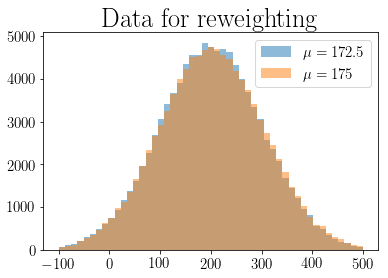

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 49us/step - loss: 8.0614 - val_loss: 8.0361
Epoch 2/10
160000/160000 [==============================] - 7s 46us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 3/10
160000/160000 [==============================] - 7s 46us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 4/10
160000/160000 [==============================] - 7s 46us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 5/10
160000/160000 [==============================] - 7s 45us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 6/10
160000/160000 [==============================] - 7s 46us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 7/10
160000/160000 [==============================] - 8s 49us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 8/10
160000/160000 [==============================] - 8s 53us/step - loss: 8.0648 - val_loss: 8.0361
Epoch 9/10
160000/160000 [==============================] - 8s 52us/step - loss: 8.0648 - val

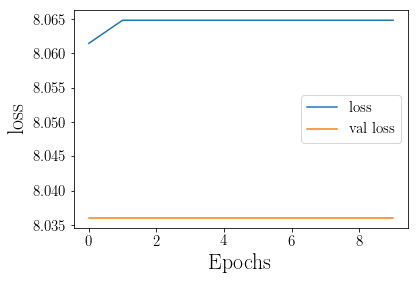

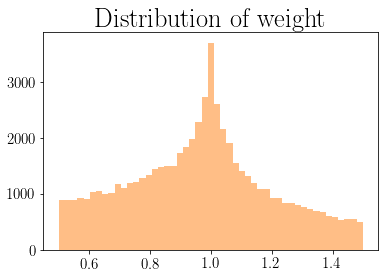

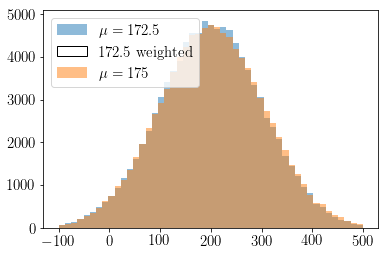

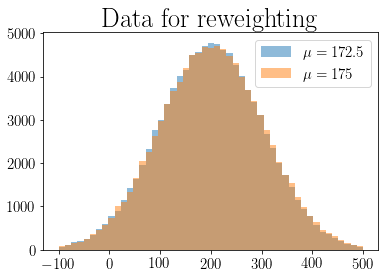

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7395 - val_loss: 0.7033
Epoch 2/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6954 - val_loss: 0.6939
Epoch 3/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6951 - val_loss: 0.6936
Epoch 4/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6952 - val_loss: 0.6936
Epoch 5/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6953 - val_loss: 0.6958
Epoch 6/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6950 - val_loss: 0.6937
Epoch 7/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6954 - val_loss: 0.6955
Epoch 8/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6953 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6952 - val

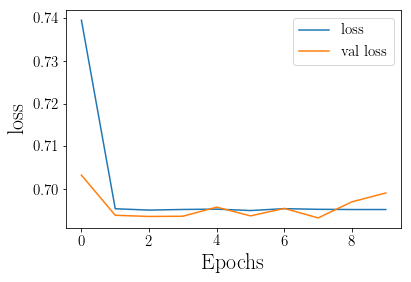

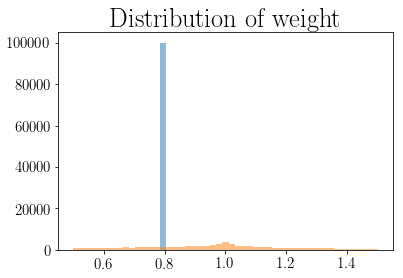

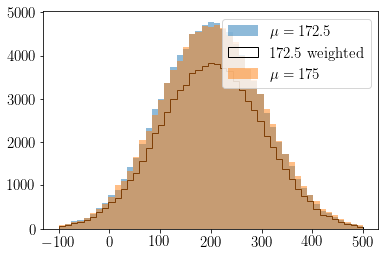

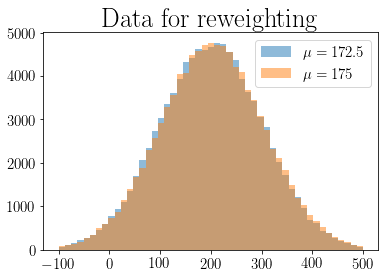

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 51us/step - loss: 1.6114 - val_loss: 0.6931
Epoch 2/10
160000/160000 [==============================] - 7s 47us/step - loss: 0.6954 - val_loss: 0.7014
Epoch 3/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6954 - val_loss: 0.6939
Epoch 4/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6953 - val_loss: 0.6934
Epoch 5/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6951 - val_loss: 0.6970
Epoch 6/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6953 - val_loss: 0.6936
Epoch 7/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6954 - val_loss: 0.6949
Epoch 8/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6952 - val_loss: 0.7021
Epoch 9/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6952 - val

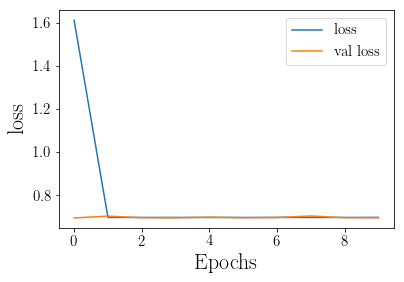

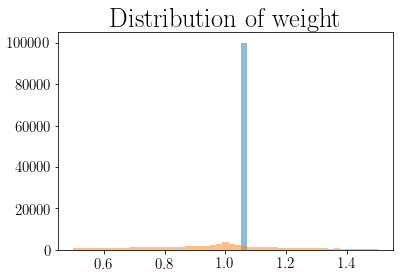

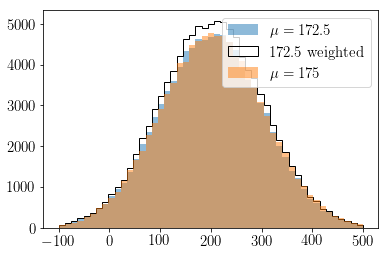

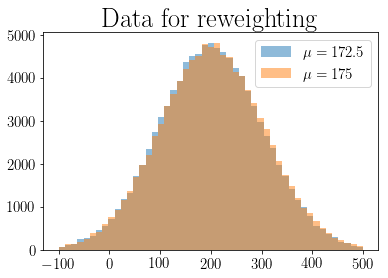

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 51us/step - loss: 1.9272 - val_loss: 0.6932
Epoch 2/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6951 - val_loss: 0.6936
Epoch 3/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6953 - val_loss: 0.6946
Epoch 4/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6952 - val_loss: 0.6948
Epoch 5/10
160000/160000 [==============================] - 7s 46us/step - loss: 0.6954 - val_loss: 0.6945
Epoch 6/10
160000/160000 [==============================] - 7s 47us/step - loss: 0.6950 - val_loss: 0.6945
Epoch 7/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6956 - val_loss: 0.6981
Epoch 8/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6952 - val_loss: 0.6936
Epoch 9/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6952 - val

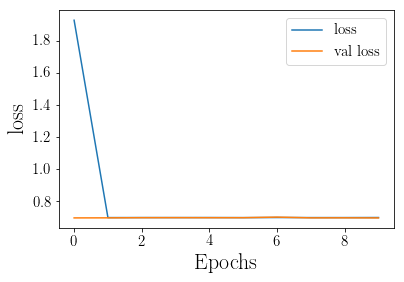

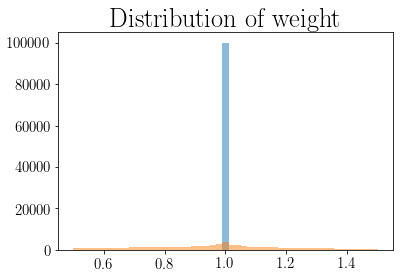

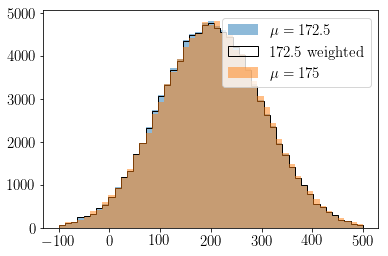

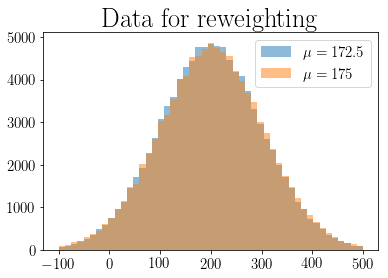

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 51us/step - loss: 8.0772 - val_loss: 7.9873
Epoch 2/10
160000/160000 [==============================] - 7s 47us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 4/10
160000/160000 [==============================] - 8s 52us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 5/10
160000/160000 [==============================] - 8s 49us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 6/10
160000/160000 [==============================] - 8s 49us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 7/10
160000/160000 [==============================] - 8s 48us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 8/10
160000/160000 [==============================] - 7s 47us/step - loss: 8.0770 - val_loss: 7.9873
Epoch 9/10
160000/160000 [==============================] - 7s 47us/step - loss: 8.0770 - val

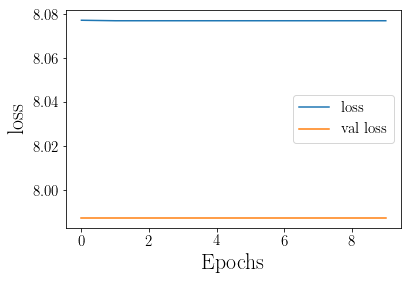

/home/csuaysom/.local/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


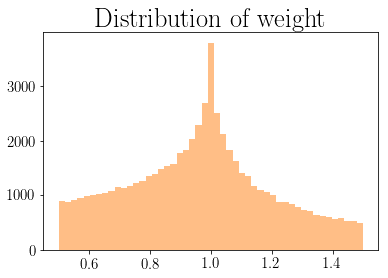

/home/csuaysom/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


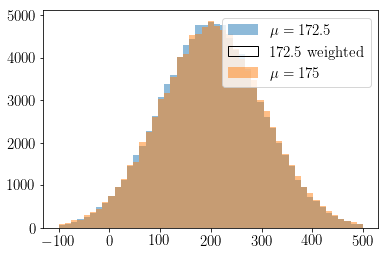

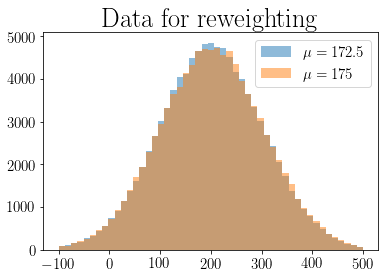

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 52us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 2/10
160000/160000 [==============================] - 8s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 3/10
160000/160000 [==============================] - 8s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 4/10
160000/160000 [==============================] - 7s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 5/10
160000/160000 [==============================] - 8s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 6/10
160000/160000 [==============================] - 8s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 7/10
160000/160000 [==============================] - 8s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 8/10
160000/160000 [==============================] - 7s 47us/step - loss: 8.0711 - val_loss: 8.0107
Epoch 9/10
160000/160000 [==============================] - 7s 46us/step - loss: 8.0711 - val

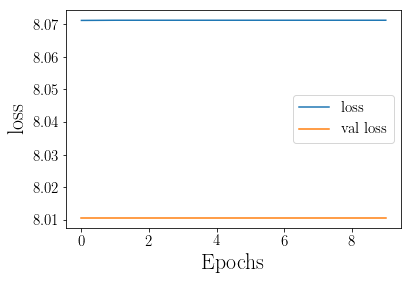

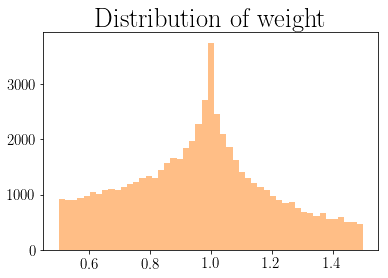

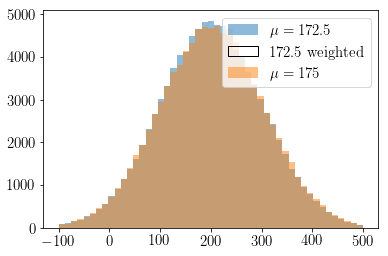

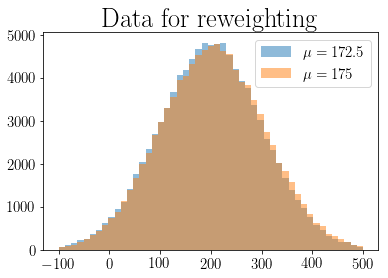

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 8s 52us/step - loss: 3.1905 - val_loss: 0.6975
Epoch 2/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6955 - val_loss: 0.6939
Epoch 3/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6952 - val_loss: 0.6931
Epoch 4/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6953 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6950 - val_loss: 0.6944
Epoch 6/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6951 - val_loss: 0.6954
Epoch 7/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6953 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6953 - val_loss: 0.6949
Epoch 9/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6950 - val

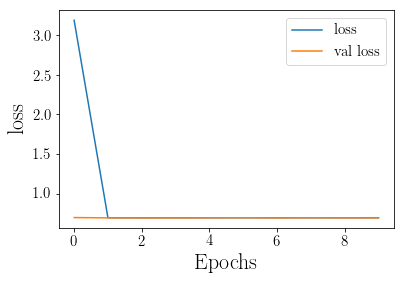

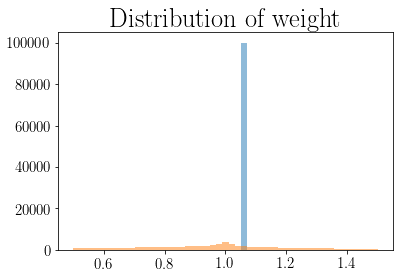

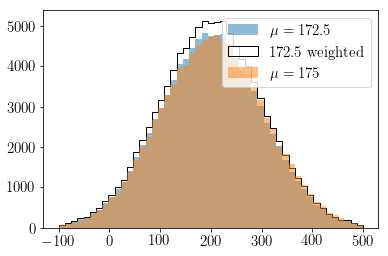

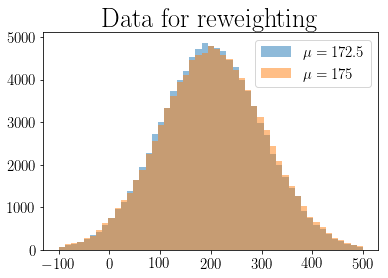

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.7026 - val_loss: 0.6932
Epoch 2/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6949 - val_loss: 0.7042
Epoch 3/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6955 - val_loss: 0.6983
Epoch 4/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6957 - val_loss: 0.6954
Epoch 5/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6951 - val_loss: 0.6942
Epoch 6/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6954 - val_loss: 0.6981
Epoch 7/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6954 - val_loss: 0.6973
Epoch 8/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6951 - val_loss: 0.6941
Epoch 9/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6953 - val

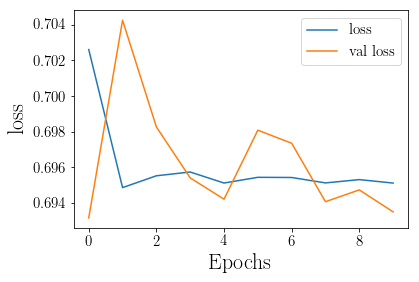

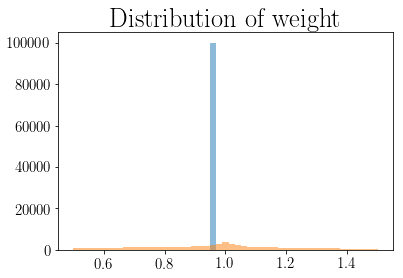

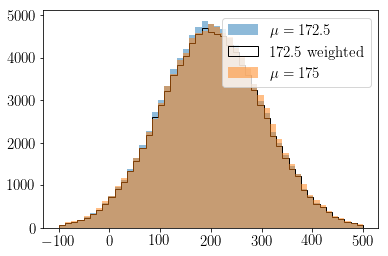

Success rate is 70.0


In [9]:
num_success = 0
for i in range(num_trial):
    convergence = reweight(10**5, lr = 0.1)
    if (convergence):
        num_success += 1

print("Success rate is", num_success*100/num_trial)

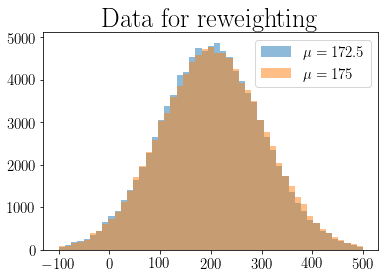

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.7434 - val_loss: 0.6939
Epoch 2/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val_loss: 0.6943
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 4/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val_loss: 0.6935
Epoch 5/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 6/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 7/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 8/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6934 - val

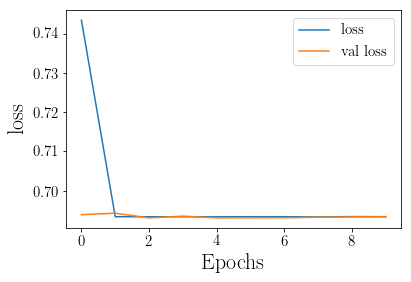

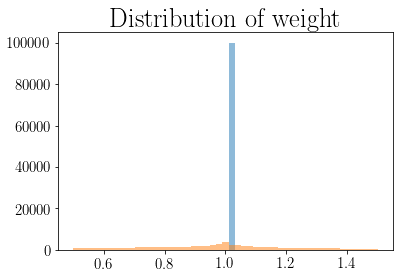

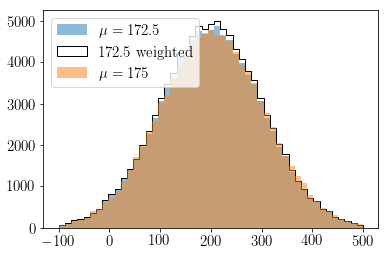

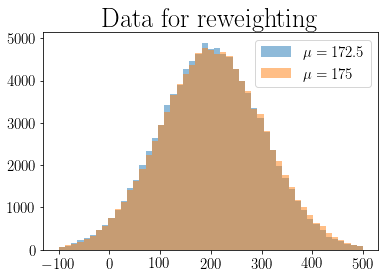

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.7110 - val_loss: 0.6936
Epoch 2/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 3/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 4/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6934 - val_loss: 0.6934
Epoch 6/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 7/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 8s 47us/step - loss: 0.6934 - val_loss: 0.6935
Epoch 9/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val

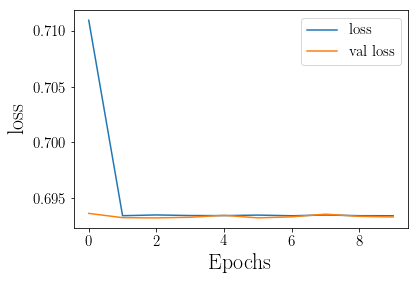

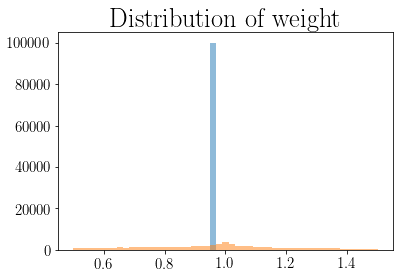

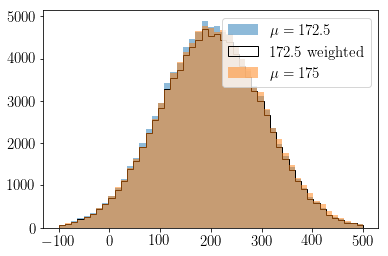

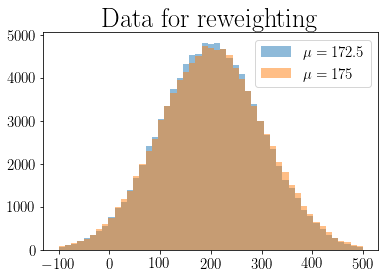

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.7436 - val_loss: 0.6934
Epoch 2/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6935
Epoch 3/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6936 - val_loss: 0.6933
Epoch 4/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 5/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6935 - val_loss: 0.6932
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6934 - val_loss: 0.6953
Epoch 7/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 8/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val

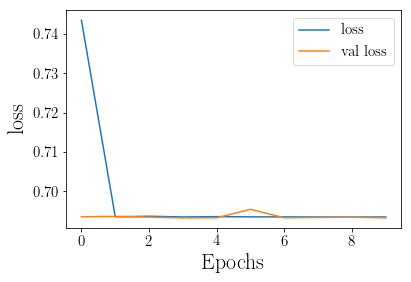

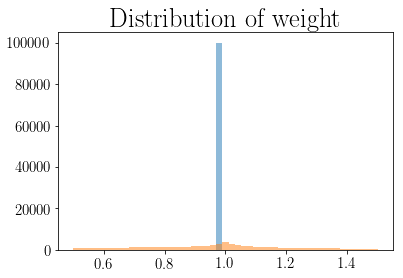

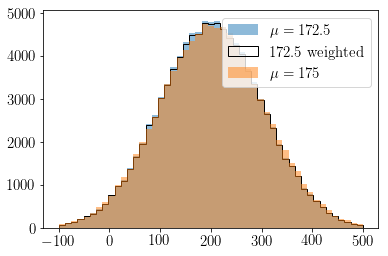

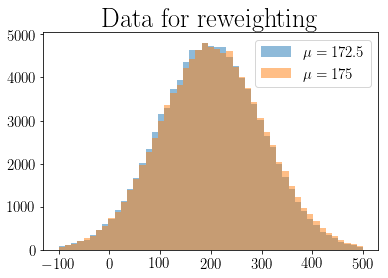

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.7637 - val_loss: 0.6931
Epoch 2/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6934
Epoch 4/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 5/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 6/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6935
Epoch 7/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 48us/step - loss: 0.6934 - val

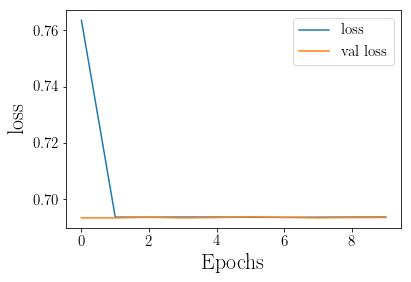

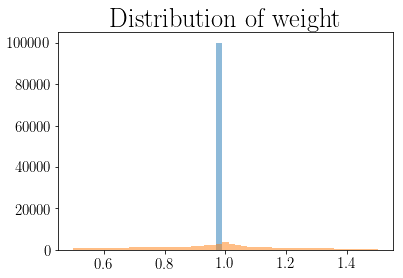

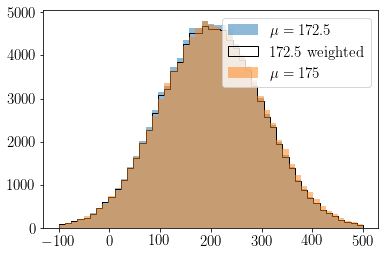

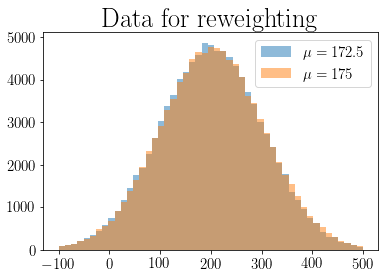

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.7053 - val_loss: 0.6932
Epoch 2/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 4/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6933 - val_loss: 0.6934
Epoch 5/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 6/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6934 - val_loss: 0.6937
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6934 - val_loss: 0.6935
Epoch 8/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val

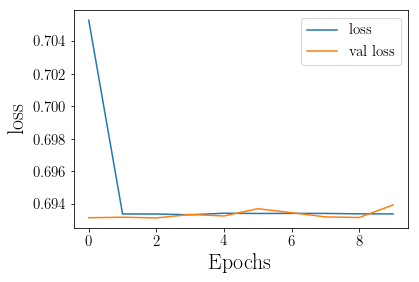

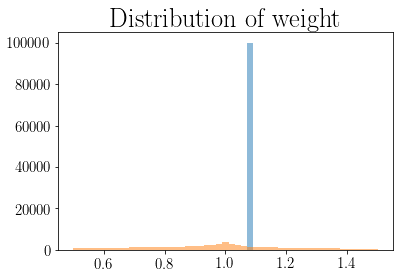

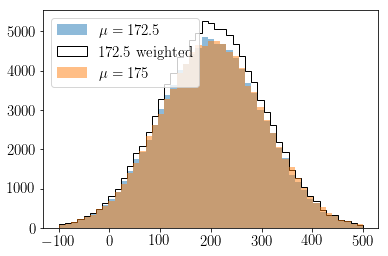

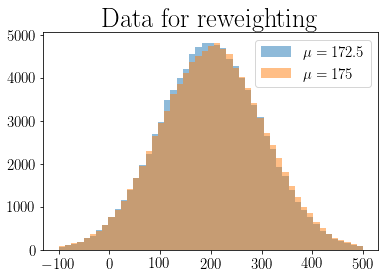

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.7088 - val_loss: 0.6932
Epoch 2/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 4/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 5/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 6/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 7/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6936
Epoch 8/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6935 - val_loss: 0.6931
Epoch 9/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val

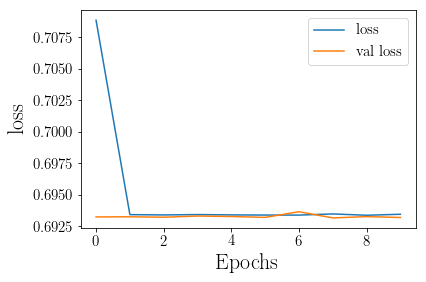

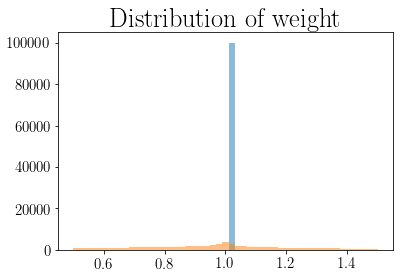

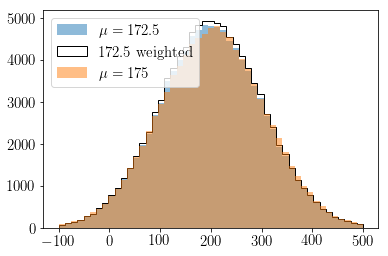

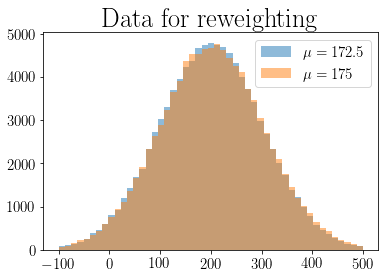

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 57us/step - loss: 7.8153 - val_loss: 7.8678
Epoch 2/10
160000/160000 [==============================] - 8s 49us/step - loss: 1.0553 - val_loss: 0.6931
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 4/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6937
Epoch 5/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6935 - val_loss: 0.6931
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6933 - val_loss: 0.6932
Epoch 7/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6934 - val_loss: 0.6937
Epoch 8/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 9/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6934 - val

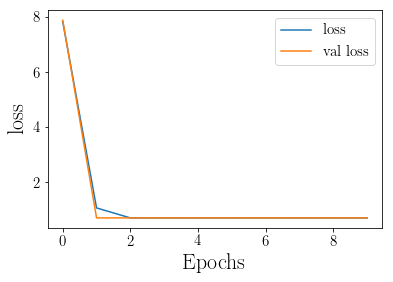

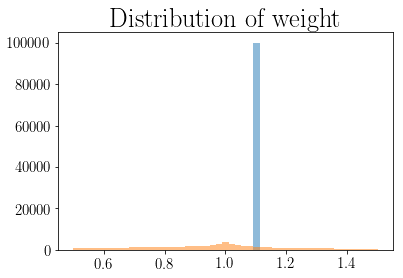

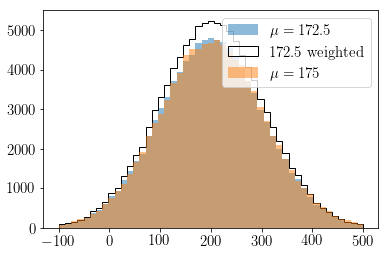

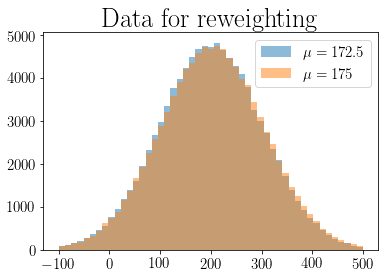

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.7049 - val_loss: 0.6932
Epoch 2/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6934
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 4/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6935 - val_loss: 0.6933
Epoch 6/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 7/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 8/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 9/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6933 - val

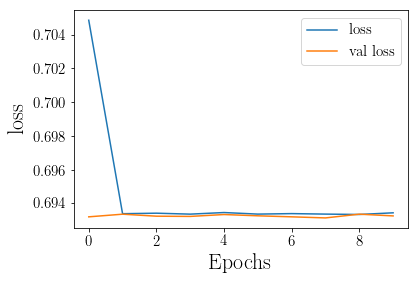

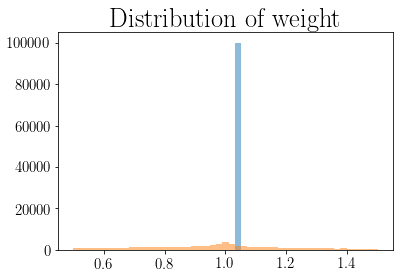

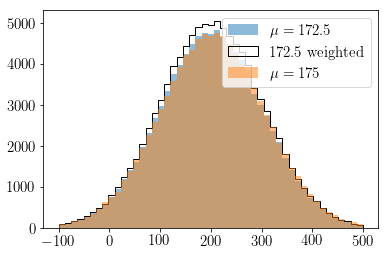

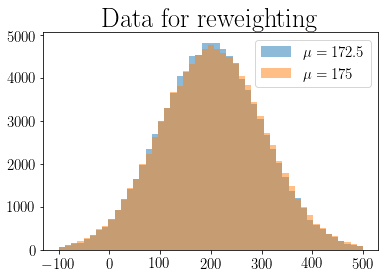

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 62us/step - loss: 0.8328 - val_loss: 0.6931
Epoch 2/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6936 - val_loss: 0.6933
Epoch 3/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 4/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6938 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 6/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - val_loss: 0.6941
Epoch 7/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6934
Epoch 8/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6933 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6934 - va

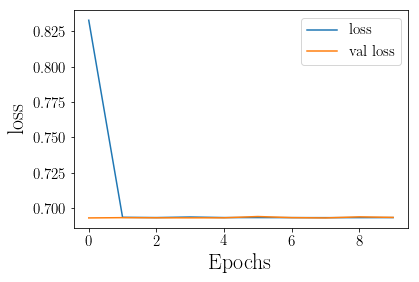

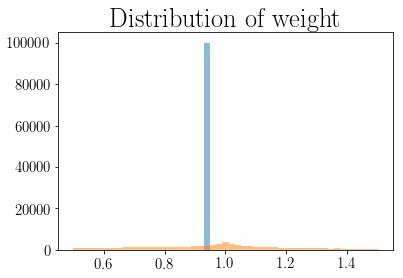

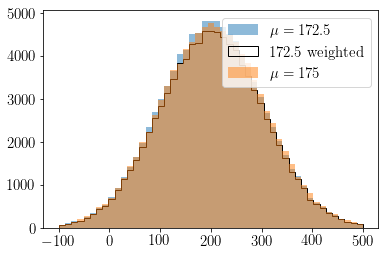

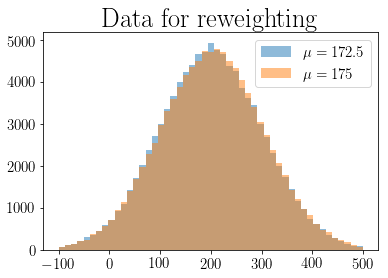

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 9s 59us/step - loss: 0.7805 - val_loss: 0.6932
Epoch 2/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6934
Epoch 3/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 4/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6933 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 49us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 7/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 8/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6934 - val

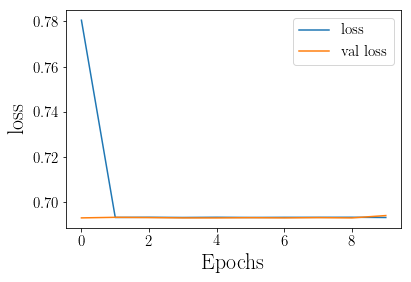

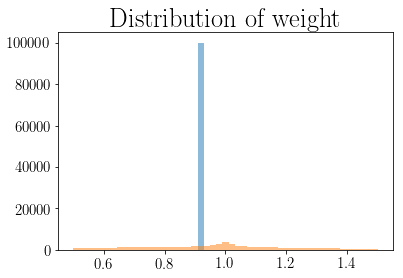

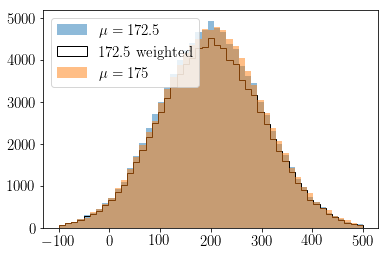

Success rate is 100.0


In [10]:
num_success = 0
for i in range(num_trial):
    convergence = reweight(10**5, lr = 0.01)
    if (convergence):
        num_success += 1

print("Success rate is", num_success*100/num_trial)

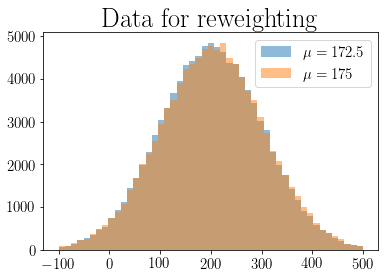

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.7463 - val_loss: 0.6938
Epoch 2/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7002 - val_loss: 0.6943
Epoch 3/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6987 - val_loss: 0.6950
Epoch 4/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6985 - val_loss: 0.6931
Epoch 5/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6969 - val_loss: 0.7071
Epoch 6/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6963 - val_loss: 0.7083
Epoch 7/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6948 - val_loss: 0.6992
Epoch 8/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6944 - val_loss: 0.6936
Epoch 9/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6941 - va

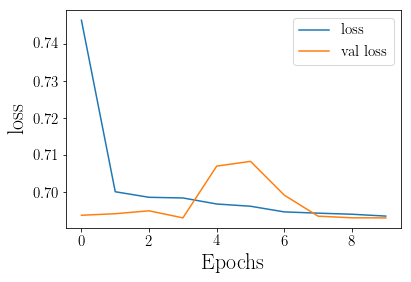

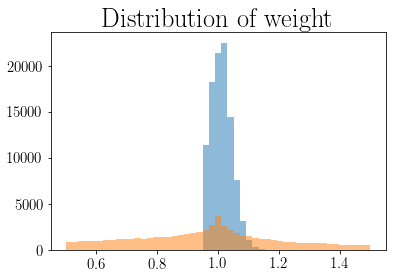

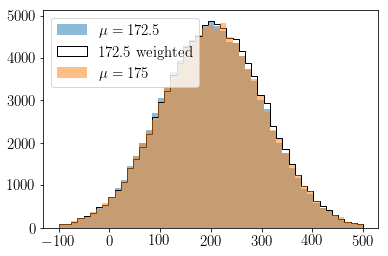

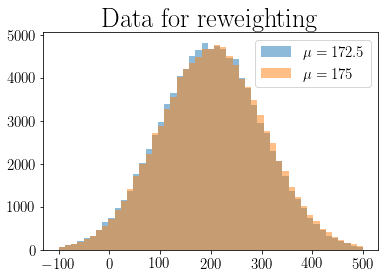

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 60us/step - loss: 0.7098 - val_loss: 0.6950
Epoch 2/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7034 - val_loss: 0.6986
Epoch 3/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7014 - val_loss: 0.6935
Epoch 4/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6998 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6974 - val_loss: 0.6960
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6962 - val_loss: 0.6974
Epoch 7/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6952 - val_loss: 0.6950
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6942 - val_loss: 0.6936
Epoch 9/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6933 - va

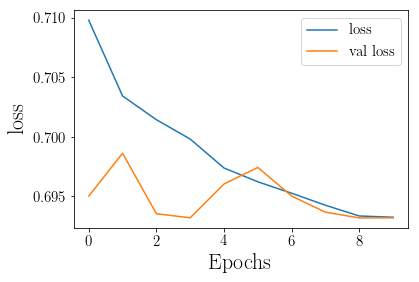

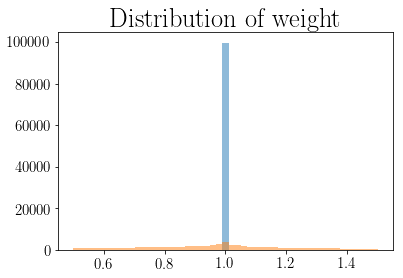

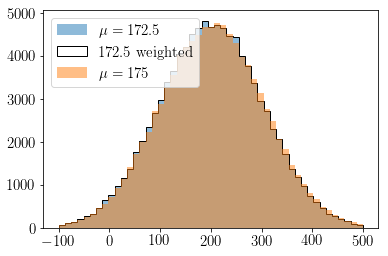

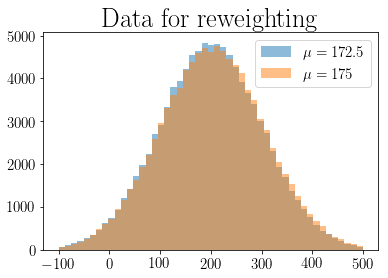

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.7427 - val_loss: 0.6941
Epoch 2/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7105 - val_loss: 0.7419
Epoch 3/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7054 - val_loss: 0.6935
Epoch 4/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6984 - val_loss: 0.7020
Epoch 5/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6953 - val_loss: 0.6933
Epoch 6/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6938 - val_loss: 0.6935
Epoch 7/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6932 - val_loss: 0.6935
Epoch 9/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6932 - va

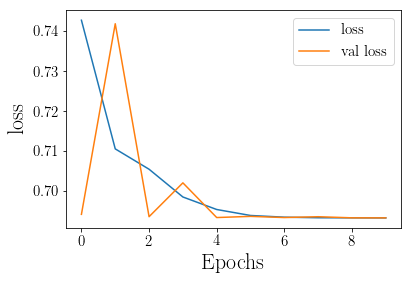

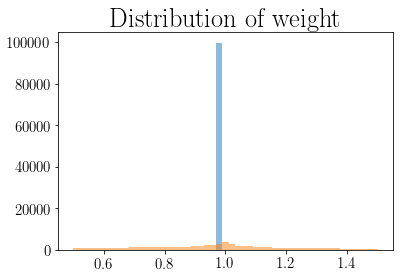

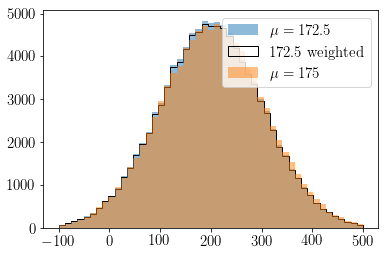

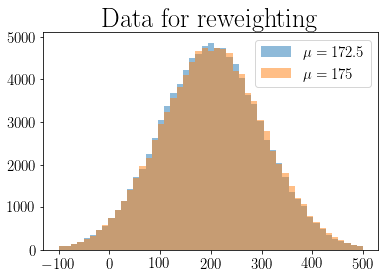

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.7422 - val_loss: 0.6933
Epoch 2/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6966 - val_loss: 0.6933
Epoch 3/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6952 - val_loss: 0.7034
Epoch 4/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6939 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6933 - val_loss: 0.6931
Epoch 6/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6932 - va

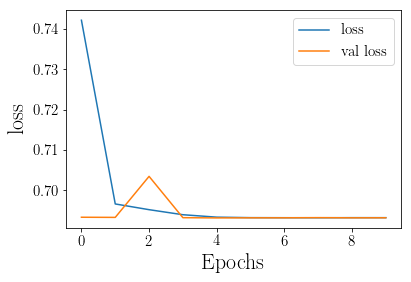

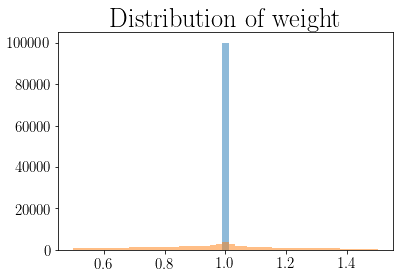

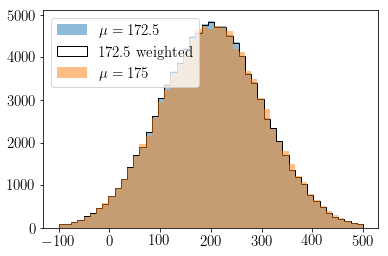

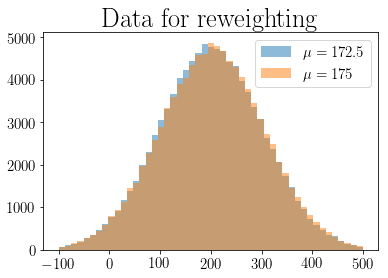

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 64us/step - loss: 0.7493 - val_loss: 0.6936
Epoch 2/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.7187 - val_loss: 0.7054
Epoch 3/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.7128 - val_loss: 0.7155
Epoch 4/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.7127 - val_loss: 0.6968
Epoch 5/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7058 - val_loss: 0.6976
Epoch 6/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7052 - val_loss: 0.7332
Epoch 7/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7007 - val_loss: 0.7072
Epoch 8/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6987 - val_loss: 0.7066
Epoch 9/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6962 - va

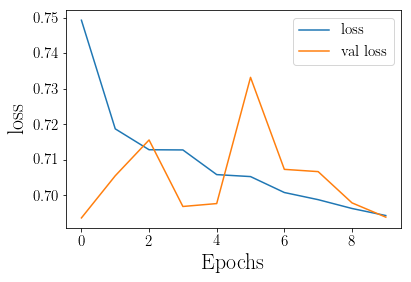

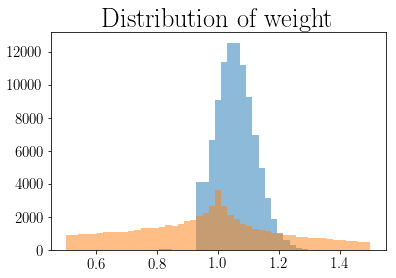

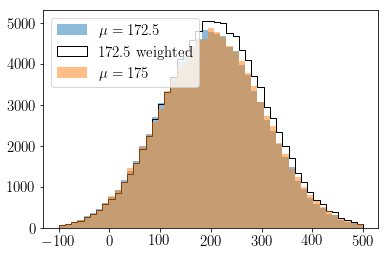

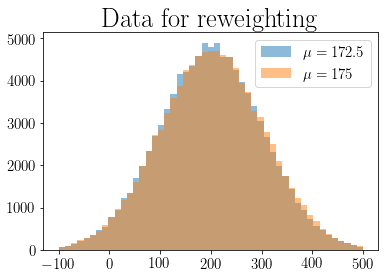

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 65us/step - loss: 0.7686 - val_loss: 0.7150
Epoch 2/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.7192 - val_loss: 0.7211
Epoch 3/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.7180 - val_loss: 0.7260
Epoch 4/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.7154 - val_loss: 0.7108
Epoch 5/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7108 - val_loss: 0.6943
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7067 - val_loss: 0.7010
Epoch 7/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7027 - val_loss: 0.7288
Epoch 8/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.6987 - val_loss: 0.6934
Epoch 9/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6944 - va

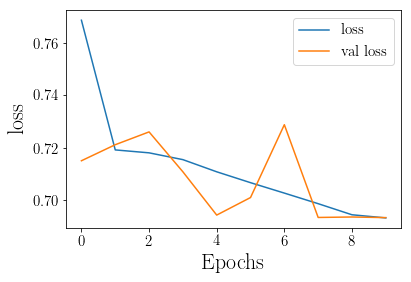

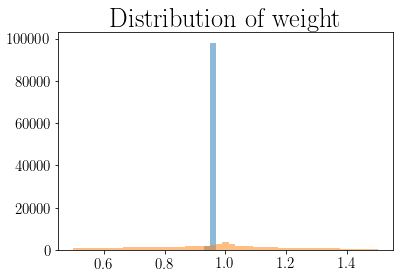

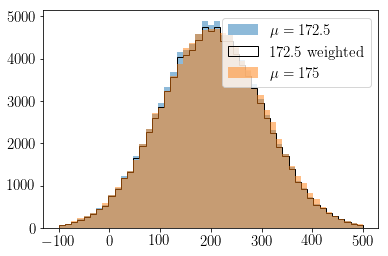

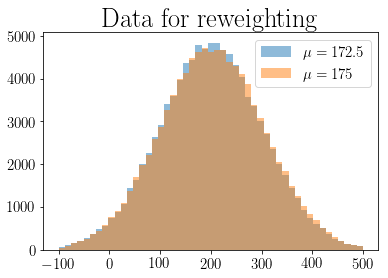

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 66us/step - loss: 0.7233 - val_loss: 0.7063
Epoch 2/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.7227 - val_loss: 0.7014
Epoch 3/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7116 - val_loss: 0.6960
Epoch 4/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7085 - val_loss: 0.6959
Epoch 5/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7097 - val_loss: 0.6934
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7055 - val_loss: 0.6993
Epoch 7/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7047 - val_loss: 0.6931
Epoch 8/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7029 - val_loss: 0.6957
Epoch 9/10
160000/160000 [==============================] - 8s 50us/step - loss: 0.7036 - va

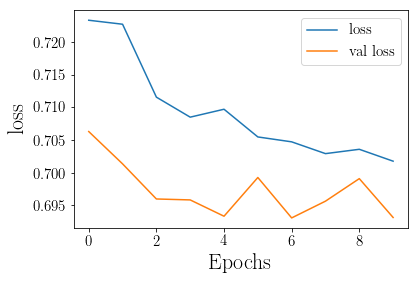

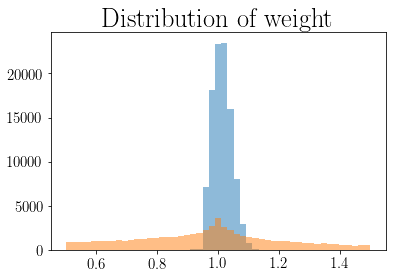

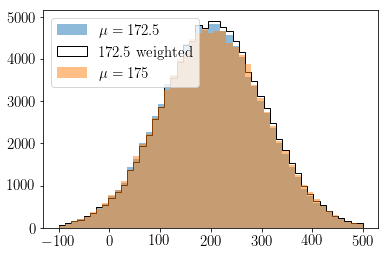

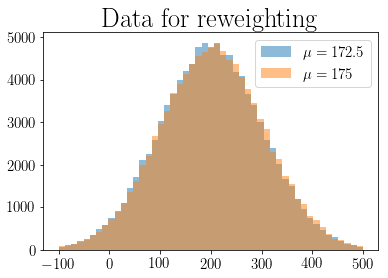

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 63us/step - loss: 0.7727 - val_loss: 0.7523
Epoch 2/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.7094 - val_loss: 0.6960
Epoch 3/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.7047 - val_loss: 0.6936
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6982 - val_loss: 0.6970
Epoch 5/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6953 - val_loss: 0.6951
Epoch 6/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6935 - val_loss: 0.6935
Epoch 7/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6932 - va

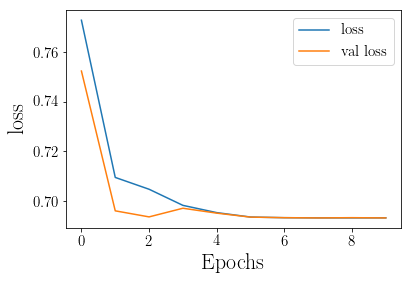

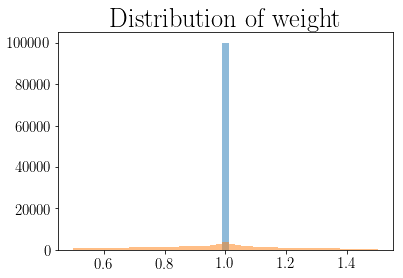

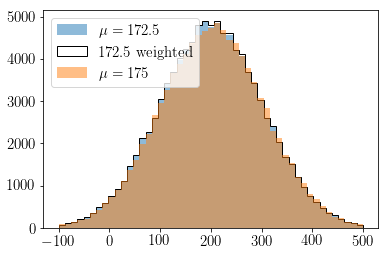

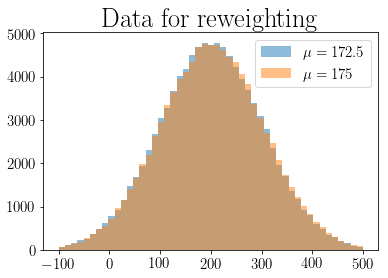

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 10s 65us/step - loss: 0.8300 - val_loss: 0.8437
Epoch 2/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7312 - val_loss: 0.7629
Epoch 3/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.7252 - val_loss: 0.7040
Epoch 4/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.7202 - val_loss: 0.7033
Epoch 5/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.7157 - val_loss: 0.7098
Epoch 6/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.7158 - val_loss: 0.7013
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.7170 - val_loss: 0.6968
Epoch 8/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.7108 - val_loss: 0.7165
Epoch 9/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.7055 - va

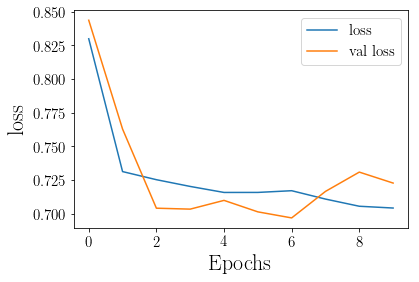

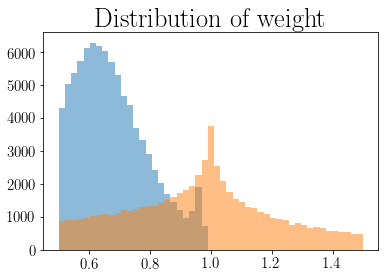

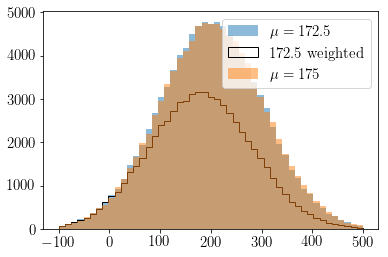

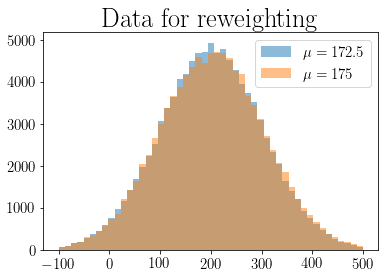

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 68us/step - loss: 0.7580 - val_loss: 0.6937
Epoch 2/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.7030 - val_loss: 0.7038
Epoch 3/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6994 - val_loss: 0.6933
Epoch 4/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6967 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6953 - val_loss: 0.6930
Epoch 6/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6936 - val_loss: 0.6935
Epoch 7/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6932 - va

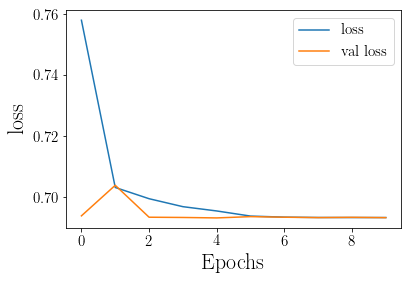

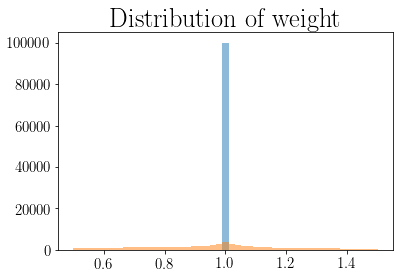

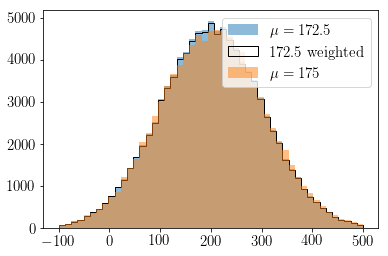

Success rate is 100.0


In [11]:
num_success = 0
for i in range(num_trial):
    convergence = reweight(10**5, lr = 0.001)
    if (convergence):
        num_success += 1

print("Success rate is", num_success*100/num_trial)

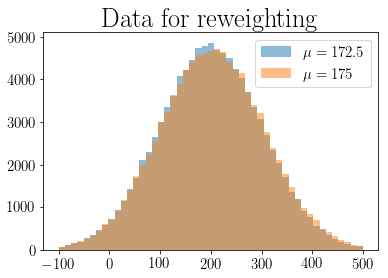

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 67us/step - loss: 0.6999 - val_loss: 0.6948
Epoch 2/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6948 - val_loss: 0.6934
Epoch 3/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6947 - val_loss: 0.6940
Epoch 4/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6947 - val_loss: 0.6944
Epoch 5/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6950 - val_loss: 0.6953
Epoch 6/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6948 - val_loss: 0.6932
Epoch 7/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6946 - val_loss: 0.6974
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6945 - val_loss: 0.6941
Epoch 9/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6946 - va

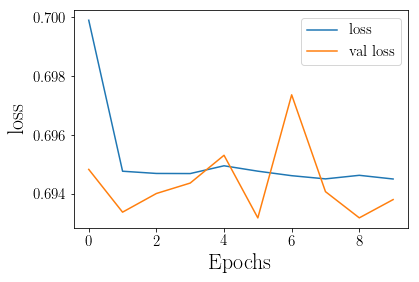

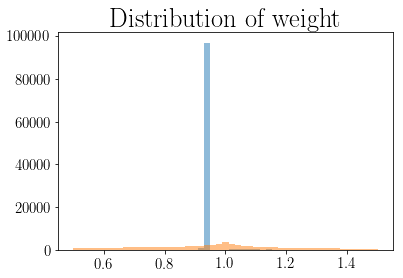

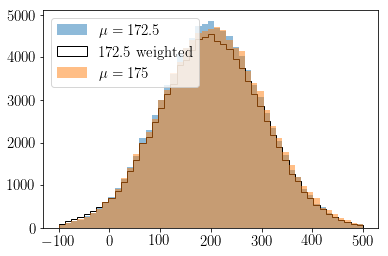

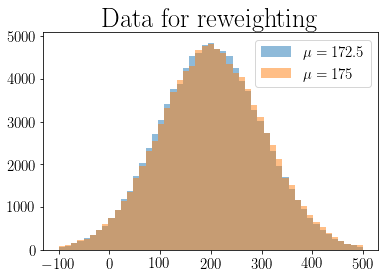

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 67us/step - loss: 0.7362 - val_loss: 0.6934
Epoch 2/10
160000/160000 [==============================] - 8s 51us/step - loss: 0.6960 - val_loss: 0.7020
Epoch 3/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6960 - val_loss: 0.6937
Epoch 4/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6969 - val_loss: 0.7008
Epoch 5/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6959 - val_loss: 0.6965
Epoch 6/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6959 - val_loss: 0.6936
Epoch 7/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6963 - val_loss: 0.6936
Epoch 8/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6968 - val_loss: 0.6987
Epoch 9/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6963 - va

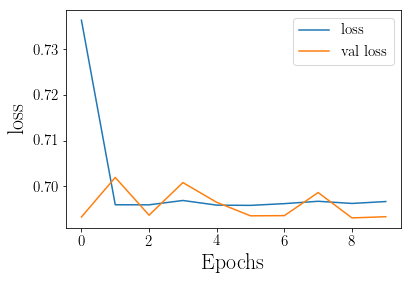

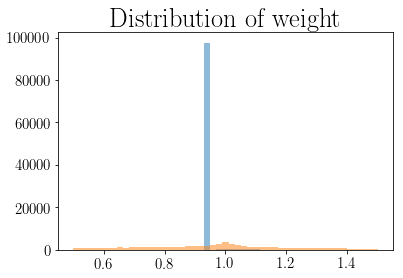

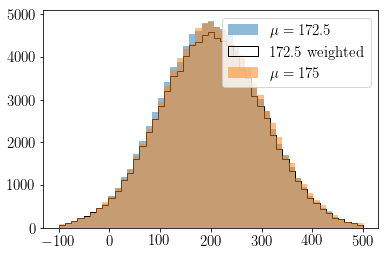

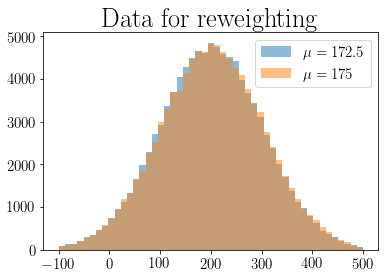

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 72us/step - loss: 0.7765 - val_loss: 0.6934
Epoch 2/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6978 - val_loss: 0.6981
Epoch 3/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6984 - val_loss: 0.7042
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6975 - val_loss: 0.6935
Epoch 5/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6976 - val_loss: 0.6968
Epoch 6/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6972 - val_loss: 0.6935
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6971 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6979 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6971 - va

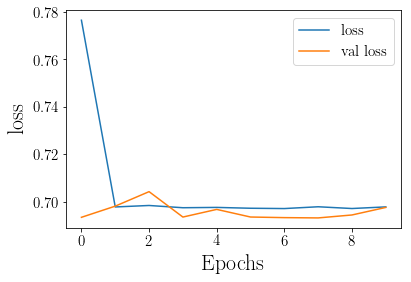

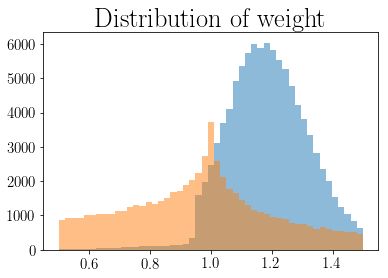

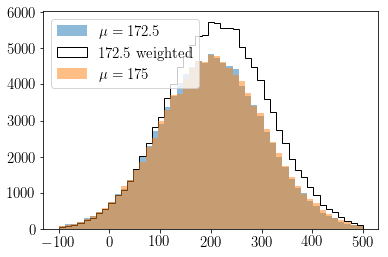

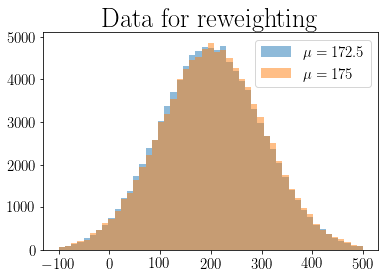

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 69us/step - loss: 0.9392 - val_loss: 0.6941
Epoch 2/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6978 - val_loss: 0.6934
Epoch 3/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6975 - val_loss: 0.6944
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6974 - val_loss: 0.6962
Epoch 5/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6976 - val_loss: 0.6946
Epoch 6/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6974 - val_loss: 0.6979
Epoch 7/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6984 - val_loss: 0.7231
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6980 - val_loss: 0.6947
Epoch 9/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6980 - va

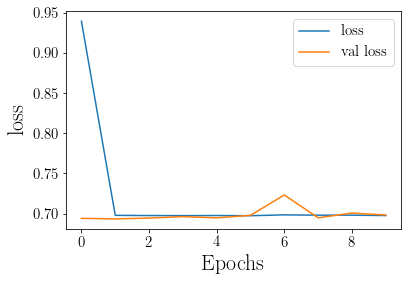

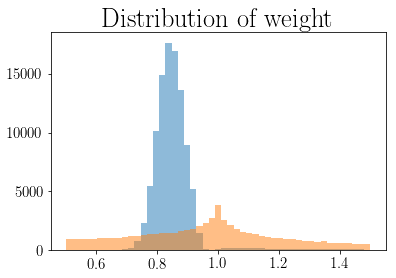

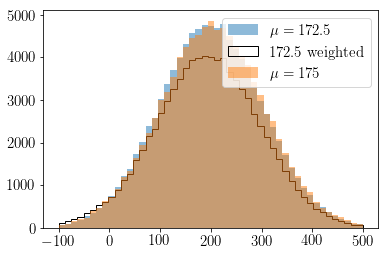

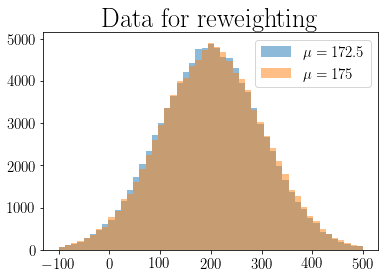

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 70us/step - loss: 0.9552 - val_loss: 0.6986
Epoch 2/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6950 - val_loss: 0.6968
Epoch 3/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6950 - val_loss: 0.7034
Epoch 4/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6948 - val_loss: 0.6988
Epoch 5/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6947 - val_loss: 0.6941
Epoch 6/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6942 - val_loss: 0.6970
Epoch 7/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6946 - val_loss: 0.6938
Epoch 8/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6950 - val_loss: 0.6967
Epoch 9/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6944 - va

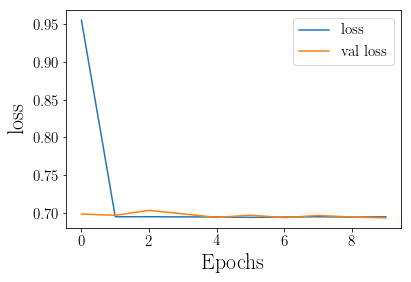

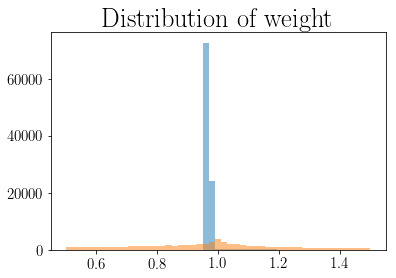

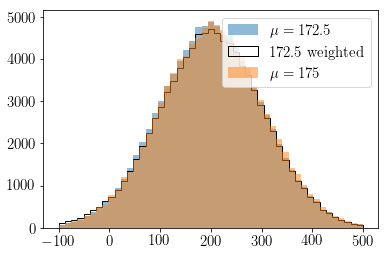

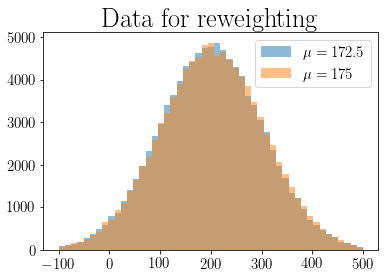

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 71us/step - loss: 0.7979 - val_loss: 0.6964
Epoch 2/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6984 - val_loss: 0.6936
Epoch 3/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6989 - val_loss: 0.7102
Epoch 4/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6985 - val_loss: 0.7024
Epoch 5/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6985 - val_loss: 0.6934
Epoch 6/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6975 - val_loss: 0.7108
Epoch 7/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6978 - val_loss: 0.6936
Epoch 8/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6982 - val_loss: 0.7211
Epoch 9/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6972 - va

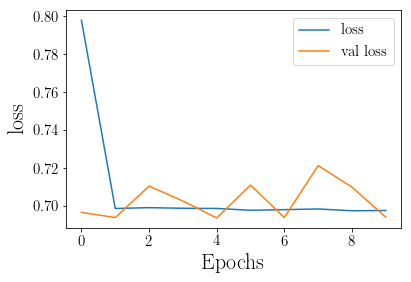

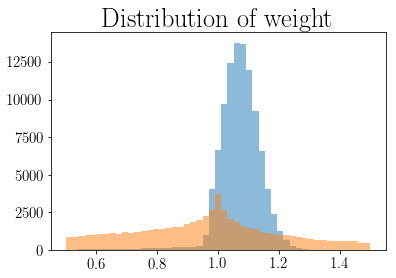

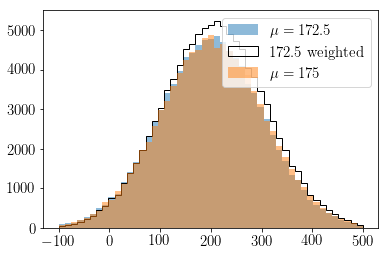

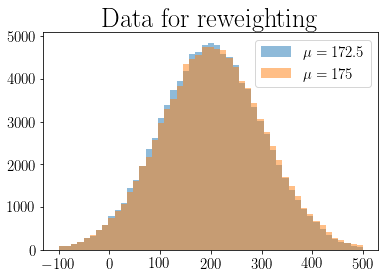

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 70us/step - loss: 0.7605 - val_loss: 0.7027
Epoch 2/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6966 - val_loss: 0.6930
Epoch 3/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6968 - val_loss: 0.6991
Epoch 4/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6967 - val_loss: 0.6940
Epoch 5/10
160000/160000 [==============================] - 8s 52us/step - loss: 0.6965 - val_loss: 0.7017
Epoch 6/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6967 - val_loss: 0.7066
Epoch 7/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6966 - val_loss: 0.6956
Epoch 8/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6968 - val_loss: 0.6931
Epoch 9/10
160000/160000 [==============================] - 8s 53us/step - loss: 0.6967 - va

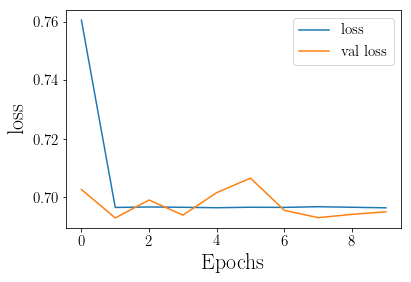

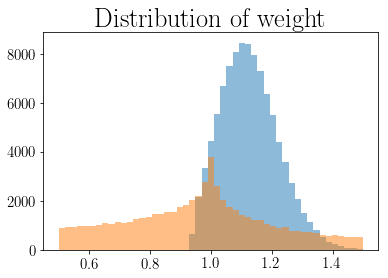

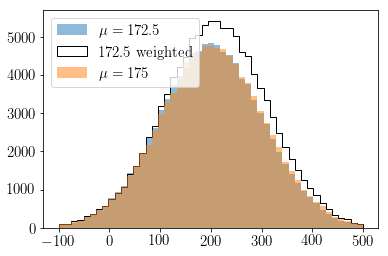

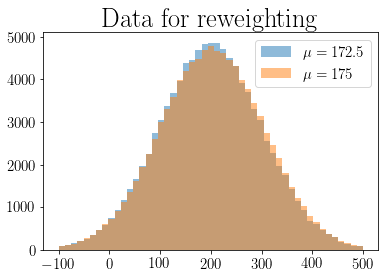

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 75us/step - loss: 1.0085 - val_loss: 0.7049
Epoch 2/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6981 - val_loss: 0.6955
Epoch 3/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6974 - val_loss: 0.6973
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6980 - val_loss: 0.6941
Epoch 5/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6977 - val_loss: 0.6972
Epoch 6/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6984 - val_loss: 0.7022
Epoch 7/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6991 - val_loss: 0.6944
Epoch 8/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6974 - val_loss: 0.7068
Epoch 9/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6982 - va

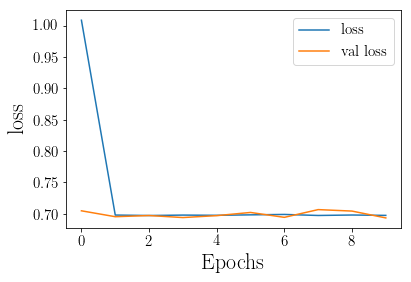

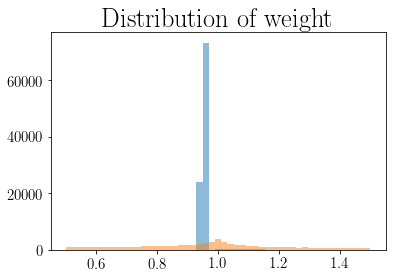

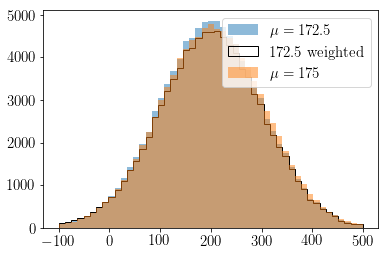

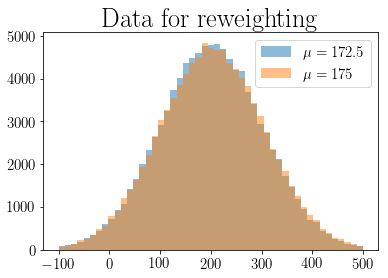

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 11s 71us/step - loss: 0.9289 - val_loss: 0.6951
Epoch 2/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6952 - val_loss: 0.6941
Epoch 3/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6951 - val_loss: 0.6938
Epoch 4/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6955 - val_loss: 0.6931
Epoch 5/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6958 - val_loss: 0.6979
Epoch 6/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6955 - val_loss: 0.6933
Epoch 7/10
160000/160000 [==============================] - 9s 53us/step - loss: 0.6953 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6952 - val_loss: 0.6945
Epoch 9/10
160000/160000 [==============================] - 9s 59us/step - loss: 0.6950 - va

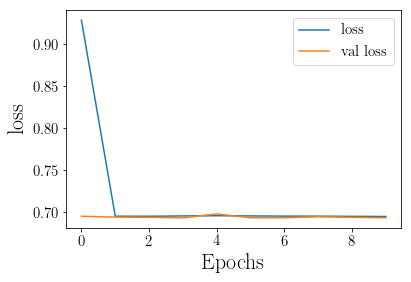

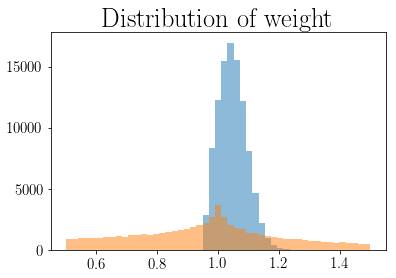

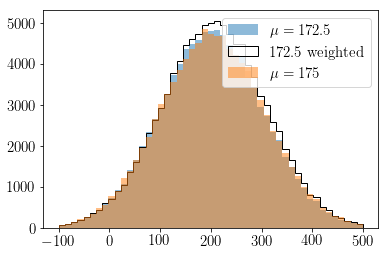

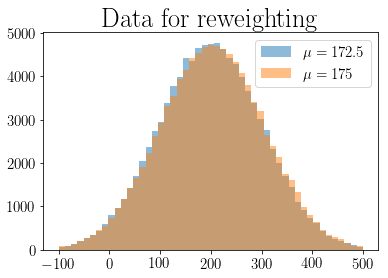

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 74us/step - loss: 0.9349 - val_loss: 0.6933
Epoch 2/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6956 - val_loss: 0.6930
Epoch 3/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6953 - val_loss: 0.6960
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6959 - val_loss: 0.6933
Epoch 5/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6956 - val_loss: 0.6930
Epoch 6/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6954 - val_loss: 0.6933
Epoch 7/10
160000/160000 [==============================] - 10s 60us/step - loss: 0.6951 - val_loss: 0.6935
Epoch 8/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6954 - val_loss: 0.6998
Epoch 9/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6954 - v

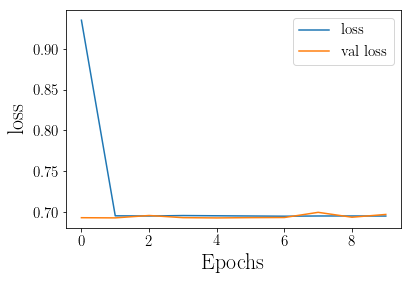

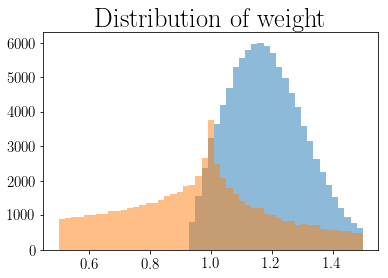

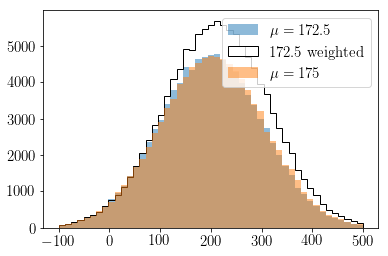

Success rate is 100.0


In [12]:
num_success = 0
for i in range(num_trial):
    convergence = reweight(10**5, lr = 0.0001)
    if (convergence):
        num_success += 1

print("Success rate is", num_success*100/num_trial)

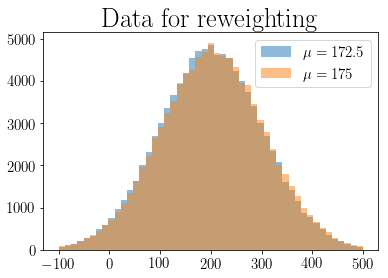

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 73us/step - loss: 5.0690 - val_loss: 1.5698
Epoch 2/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.8296 - val_loss: 0.6935
Epoch 3/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6931 - val_loss: 0.6935
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6932 - val_loss: 0.6934
Epoch 5/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6931 - val_loss: 0.6935
Epoch 6/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6931 - val_loss: 0.6934
Epoch 7/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6932 - val_loss: 0.6934
Epoch 8/10
160000/160000 [==============================] - 9s 59us/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6931 - va

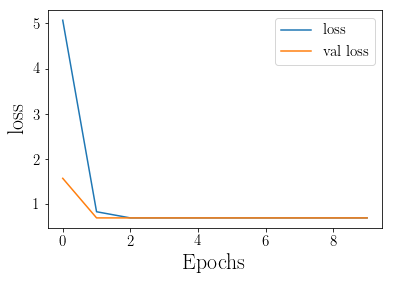

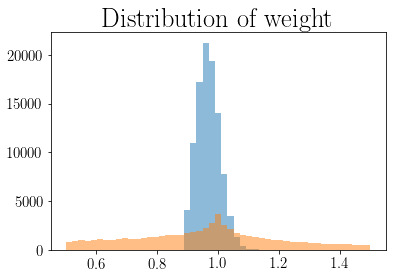

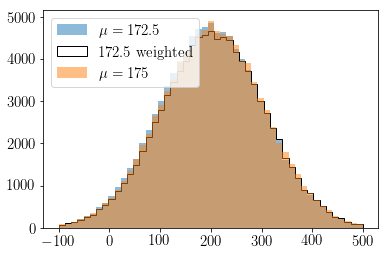

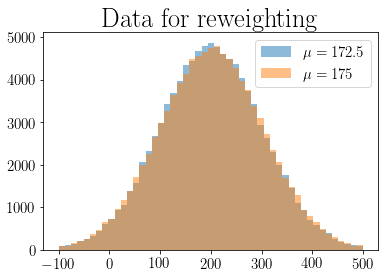

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 76us/step - loss: 1.6157 - val_loss: 0.6964
Epoch 2/10
160000/160000 [==============================] - 10s 60us/step - loss: 0.6940 - val_loss: 0.6933
Epoch 3/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6936 - val_loss: 0.6935
Epoch 4/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6936 - val_loss: 0.6935
Epoch 5/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6936 - val_loss: 0.6936
Epoch 6/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6936 - val_loss: 0.6932
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6936 - val_loss: 0.6939
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6935 - v

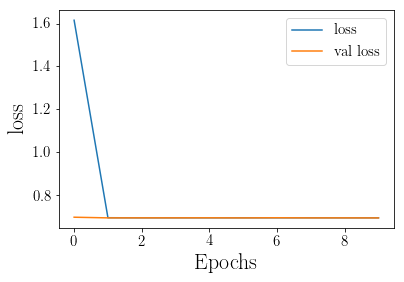

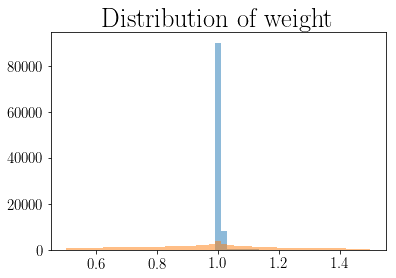

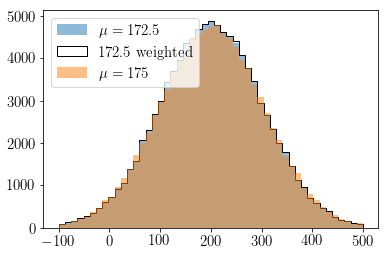

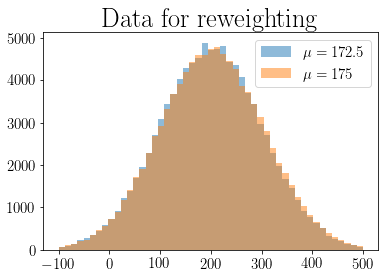

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 76us/step - loss: 3.8308 - val_loss: 0.7190
Epoch 2/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.7015 - val_loss: 0.6940
Epoch 3/10
160000/160000 [==============================] - 10s 60us/step - loss: 0.6936 - val_loss: 0.6944
Epoch 4/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6937 - val_loss: 0.6937
Epoch 5/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6936 - val_loss: 0.6966
Epoch 6/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6944
Epoch 7/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6936 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6936 - val_loss: 0.6955
Epoch 9/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6936 - v

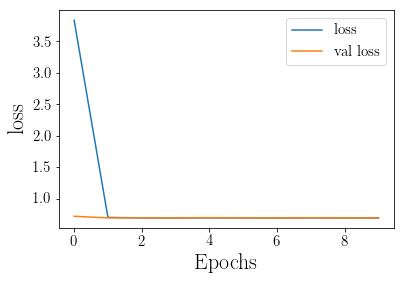

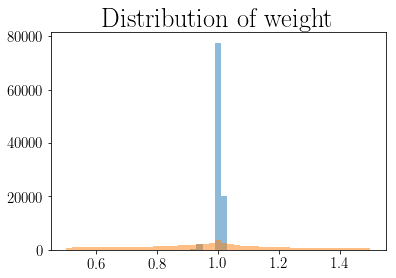

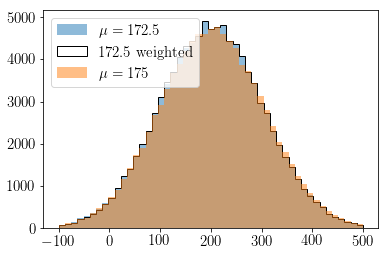

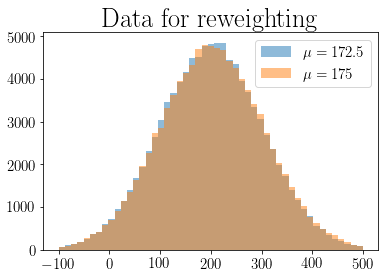

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 76us/step - loss: 4.7086 - val_loss: 0.7130
Epoch 2/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6938 - val_loss: 0.6931
Epoch 3/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6932 - val_loss: 0.6935
Epoch 4/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6933 - val_loss: 0.6931
Epoch 6/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 8/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6933 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6932 - va

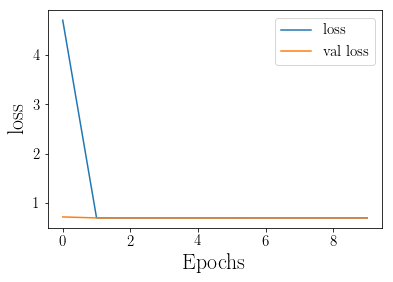

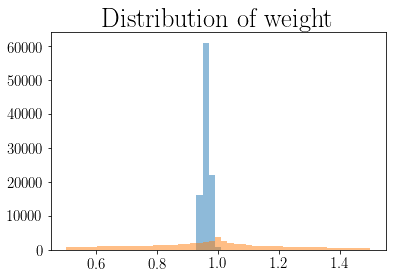

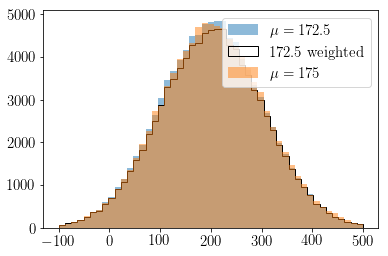

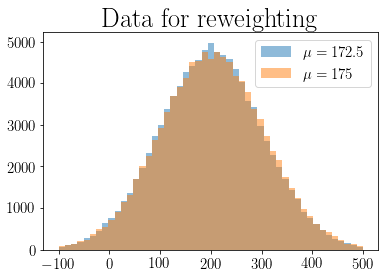

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 13s 79us/step - loss: 1.9803 - val_loss: 0.6931
Epoch 2/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6933 - val_loss: 0.6931
Epoch 5/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6933 - val_loss: 0.6930
Epoch 6/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6932 - val_loss: 0.6930
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6933 - val_loss: 0.6931
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6933 - val_loss: 0.6932
Epoch 9/10
160000/160000 [==============================] - 9s 54us/step - loss: 0.6933 - va

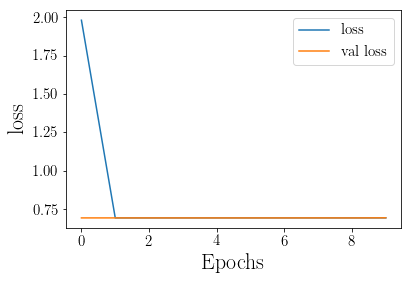

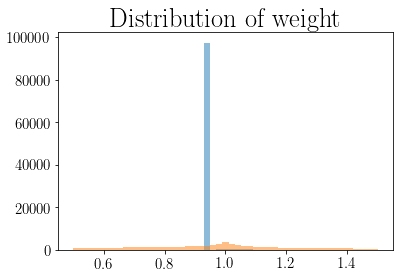

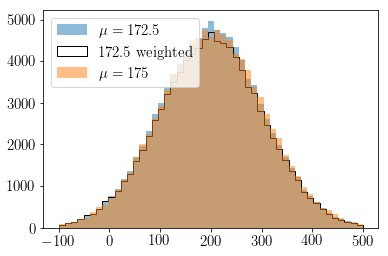

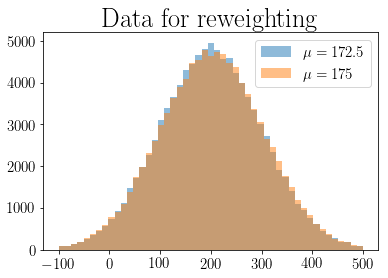

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 13s 79us/step - loss: 7.1302 - val_loss: 4.9307
Epoch 2/10
160000/160000 [==============================] - 9s 57us/step - loss: 1.2805 - val_loss: 0.6942
Epoch 3/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.6939 - val_loss: 0.6939
Epoch 4/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6938 - val_loss: 0.6937
Epoch 5/10
160000/160000 [==============================] - 9s 59us/step - loss: 0.6937 - val_loss: 0.6937
Epoch 6/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6937 - val_loss: 0.6935
Epoch 7/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6936 - val_loss: 0.6935
Epoch 8/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6935 - val_loss: 0.6935
Epoch 9/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6935 - v

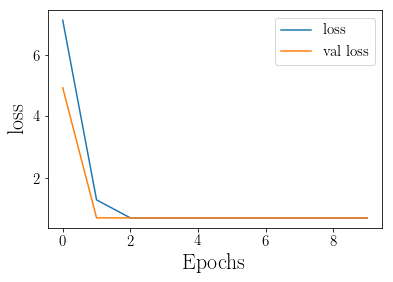

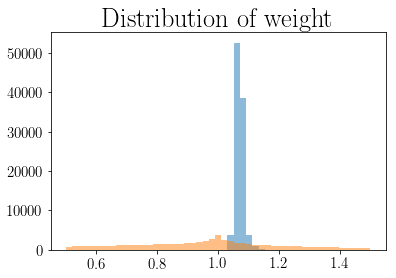

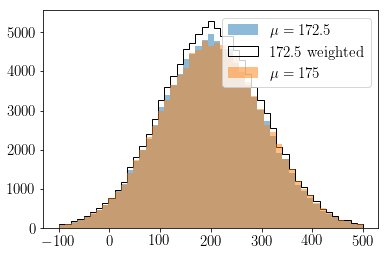

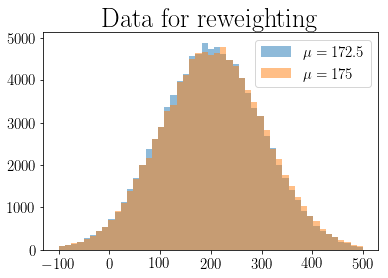

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 76us/step - loss: 5.2059 - val_loss: 0.6934
Epoch 2/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6939 - val_loss: 0.6954
Epoch 3/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6939 - val_loss: 0.6932
Epoch 4/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6939 - val_loss: 0.6948
Epoch 5/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6942 - val_loss: 0.6951
Epoch 6/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.6941 - val_loss: 0.6968
Epoch 7/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6941 - val_loss: 0.6937
Epoch 8/10
160000/160000 [==============================] - 9s 59us/step - loss: 0.6939 - val_loss: 0.7005
Epoch 9/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.6939 - 

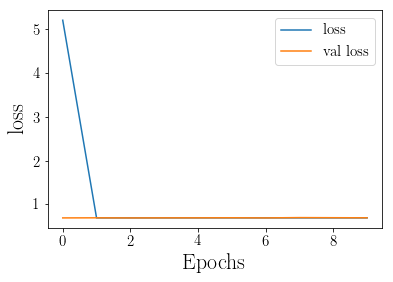

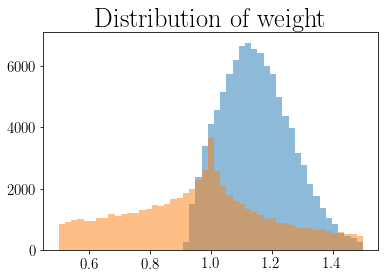

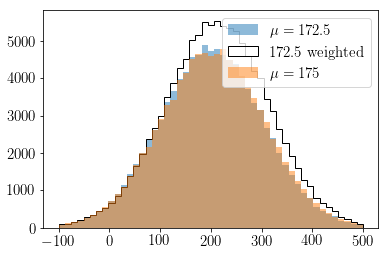

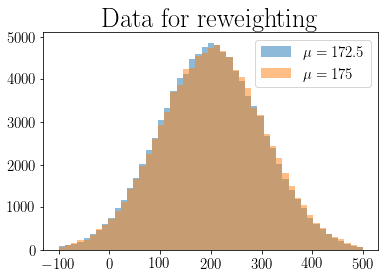

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 78us/step - loss: 0.7577 - val_loss: 0.6934
Epoch 2/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6934 - val_loss: 0.6942
Epoch 3/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6938
Epoch 4/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6931
Epoch 5/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6931
Epoch 6/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6936
Epoch 7/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6937
Epoch 8/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - val_loss: 0.6931
Epoch 9/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 - va

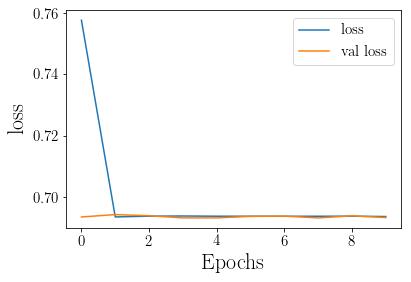

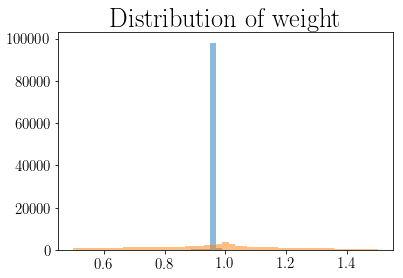

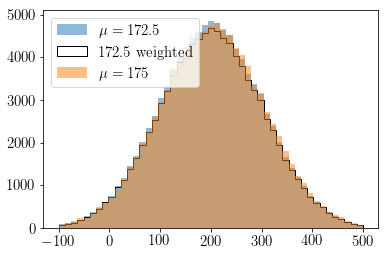

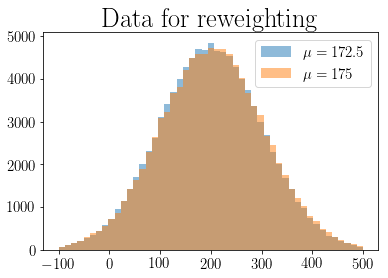

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 13s 78us/step - loss: 4.2594 - val_loss: 0.6936
Epoch 2/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6937 - val_loss: 0.6935
Epoch 3/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.6937 - val_loss: 0.6935
Epoch 4/10
160000/160000 [==============================] - 10s 61us/step - loss: 0.6938 - val_loss: 0.6936
Epoch 5/10
160000/160000 [==============================] - 10s 60us/step - loss: 0.6937 - val_loss: 0.6937
Epoch 6/10
160000/160000 [==============================] - 9s 58us/step - loss: 0.6936 - val_loss: 0.6938
Epoch 7/10
160000/160000 [==============================] - 9s 57us/step - loss: 0.6936 - val_loss: 0.6934
Epoch 8/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6936 - val_loss: 0.6933
Epoch 9/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6937 -

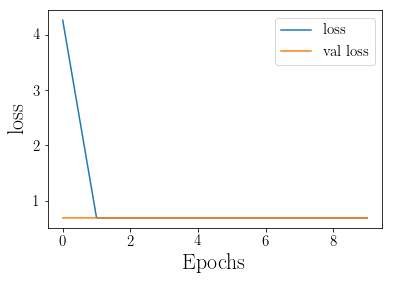

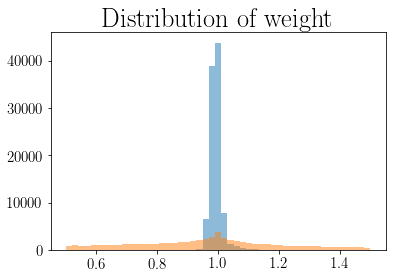

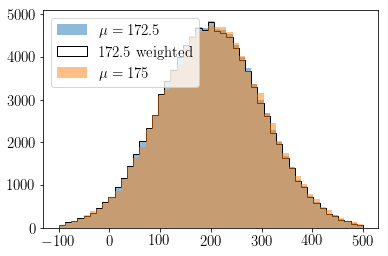

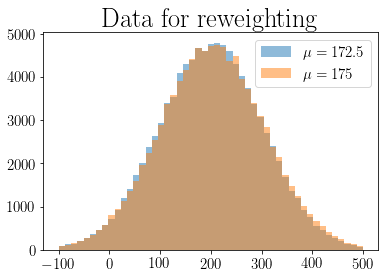

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 13s 79us/step - loss: 1.4493 - val_loss: 0.7116
Epoch 2/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.7043 - val_loss: 0.6982
Epoch 3/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6954 - val_loss: 0.6937
Epoch 4/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6935 - val_loss: 0.6933
Epoch 5/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6934 - val_loss: 0.6932
Epoch 6/10
160000/160000 [==============================] - 9s 55us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 7/10
160000/160000 [==============================] - 9s 56us/step - loss: 0.6934 - val_loss: 0.6936
Epoch 8/10
160000/160000 [==============================] - 9s 59us/step - loss: 0.6934 - val_loss: 0.6937
Epoch 9/10
160000/160000 [==============================] - 10s 62us/step - loss: 0.6934 - v

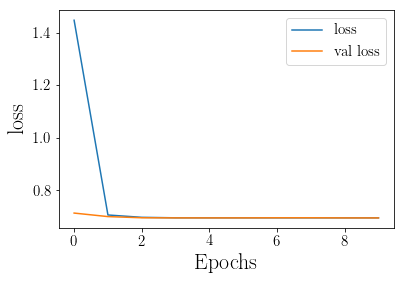

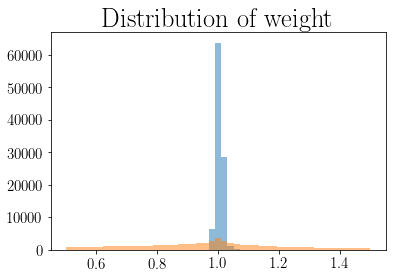

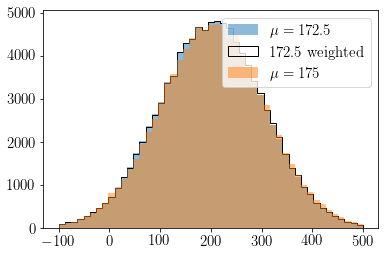

Success rate is 100.0


In [13]:
num_success = 0
for i in range(num_trial):
    convergence = reweight(10**5, lr = 0.00001)
    if (convergence):
        num_success += 1

print("Success rate is", num_success*100/num_trial)